In [21]:
import pandas as pd
import datetime as dt
from IPython.display import display
from sklearn.impute import SimpleImputer
import os
import tensorflow as tf

# tf.config.experimental.set_memory_growth(gpus[0], True)

# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')

class DataPreprocessor:
    def __init__(self, filename):
        self.filename = filename
        self.df = pd.read_csv(self.filename)
    
    def drop_duplicates(self):
        remove_duplicates = input("Do you want to remove duplicates? Input T or F ") == "T"
        if remove_duplicates:
            self.df.drop_duplicates(inplace=True)
    
    def impute_missing(self, method='mean'):
        
        impute_strategy = input("How do you want to impute your missing values? e.g. \"median\", \"0\" " )
        imputer = SimpleImputer()
        if impute_strategy.isdigit():
            imputer = SimpleImputer(strategy='constant', fill_value=int(impute_strategy))
        else:
            imputer = SimpleImputer(strategy = impute_strategy)
        self.df = pd.DataFrame(imputer.fit_transform(self.df), columns=self.df.columns)
            
    def display_table(self):
        display(self.df)
        to_csv = input("This is your new data file -- do you want to download it? Input T or F ") == "T"
        if to_csv:
            # Get the current timestamp
            timestamp = dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

            # Define the output filename
            # Split the filename into basename and extension
            basename, extension = os.path.splitext(self.filename)
            download_filename = f'{basename}_{timestamp}{extension}'

            # Download the dataframe to the output file
            self.df.to_csv(download_filename, index=False)
            
    def return_data(self):
        return self.df.iloc[:, :-1].values
        
    def return_labels(self):
        return self.df.iloc[:, -1].values


In [34]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class DimensionReduction():
    def __init__(self, n_components):
        self.model = None
        self.n_components = n_components
    
    def fit_transform(self, data):
        pass
    
class MyPCA(DimensionReduction):
    def __init__(self, n_components):
        super().__init__(n_components)
    
    def fit_transform(self, data):
        self.model = PCA(n_components=self.n_components)
        X_pca = self.model.fit_transform(data)
        return X_pca

class MyTSNE(DimensionReduction):
    def __init__(self, n_components):
        super().__init__(n_components)
    
    def fit_transform(self, data):
        self.model = TSNE(n_components=self.n_components, perplexity=30, n_iter=500)
        X_tsne = self.model.fit_transform(data)
        return X_tsne

In [9]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, recall_score, precision_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

class Clustering:
    def __init__(self, data):
        self.model = None
        self.data = data
        self.pc_to_plot = 2
        
        #used to calculate different scores, if needed
        self.labels = None
    
    def f1_score(self, labels_true):
        return f1_score(labels_true, self.labels)
    
    def recall_score(self, labels_true):
        return recall_score(labels_true, self.labels)
    
    def precision_score(self, labels_true):
        return precision_score(labels_true, self.labels)
    
    def silhouette_score(self, data):
        return silhouette_score(data, self.labels)
    
    def cluster(self):
        raise NotImplementedError()
    
    def plot_clusters(self, model):
        # Fit PCA to the data
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.data)
        
        # Get the cluster labels and the number of clusters
        labels = self.labels
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Plot the data points colored by cluster
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
        plt.title(f'Clustering on PCA (Number of Clusters: {n_clusters})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        
        # Remove values on the x and y axes
        plt.tick_params(labelbottom=False, labelleft=False)
        
        #Show the plot
        plt.show()

class KMeansClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def elbow_method(self):
        # Calculate the within-cluster sum of squares (WCSS) for each k value
        wcss = []
        
        # Define range of k values to test
        k_values = range(1, 10)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(self.data)
            wcss.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.plot(k_values, wcss, 'bx-')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('WCSS')
        plt.title('Elbow Method')

        # Determine the optimal number of clusters
        diffs = np.diff(wcss)
        diff_ratios = diffs[1:] / diffs[:-1]
        optimal_k = k_values[np.argmin(diff_ratios) + 1]

        # Display the optimal number of clusters
        plt.axvline(x=optimal_k, linestyle='--', color='r', label=f'Optimal k={optimal_k}')
        plt.legend()
        plt.show()

        print(f"Optimal number of clusters: {optimal_k}")
        
        return optimal_k
    
    def cluster(self, n_clusters=None):
        warnings.filterwarnings("ignore")
        if n_clusters is None:
            n_clusters = self.elbow_method()
        kmeans = KMeans(n_clusters=n_clusters)
        self.model = kmeans
        self.labels = kmeans.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)

class DBSCANClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, eps=None, min_samples=None):
        warnings.filterwarnings("ignore")
        if eps is None:
#             eps = np.sqrt(self.data.shape[1])
            eps=5000
        if min_samples is None:
            min_samples = 2 * self.data.shape[1]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.model = dbscan
        self.labels = dbscan.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.cluster import AgglomerativeClustering

class AgglomerativeClusteringAlgorithm(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    # The linkage parameter specifies the method used to compute the distance between clusters. 
    # It determines the way clusters are merged during the hierarchical clustering process.
    def cluster(self, n_clusters=2, linkage='ward'):
        self.model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        self.labels = model.fit_predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.cluster import MeanShift

class MeanShiftClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self):
        self.model = MeanShift()
        self.labels = self.model.fit_predict(self.data)
        self.centers = self.model.cluster_centers_
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.ensemble import IsolationForest

class IsolationForestClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)

    def cluster(self, contamination=None):
        if contamination is None:
            contamination = 0.05
        self.model = IsolationForest(contamination=contamination)
        self.model.fit(self.data)
        self.labels = self.model.predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        
from sklearn.mixture import BayesianGaussianMixture

class BGMMClustering(Clustering):
    def __init__(self, data):
        super().__init__(data)
    
    def cluster(self, n_components=None):
        if n_components is None:
            n_components = 2
        self.model = BayesianGaussianMixture(n_components=n_components)
        self.model.fit(self.data)
        self.labels = self.model.predict(self.data)
        
        #plot the clusters
        self.plot_clusters(self.model)
        

In [10]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2D, MaxPooling2D, UpSampling2D, Cropping1D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt

class DLModel:
    def __init__(self):
        self.model = None
        self.history = None

    def train(self):
        pass

    def detect(self, new_data):
        pass

    def define_model(self):
        pass

    def save_model(self):

        # Get the current time as a string
        timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')

        # Construct the filename with the timestamp
        filename = f'my_model_{timestamp}.h5'

        # Save the model to the file with the timestamped name
        self.model.save(filename)

        # Print message indicating the model has been saved
        print(f'Model saved to {filename}')

class AnomalyDetectionModel(DLModel):
    def __init__(self):
        super().__init__()

class ConvolutionalAutoencoder(AnomalyDetectionModel):

    def __init__(self):
        super().__init__()

    def define_model(self, height, width):
        #Feel free to adjust this accordingly
        x = Input(shape=(height, width, 1))

        # Encoder
        conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
        conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
        conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
        h = MaxPooling2D((2, 2), padding='same')(conv1_3)

        # Decoder
        conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
        up1 = UpSampling2D((2, 2))(conv2_1)
        conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
        up2 = UpSampling2D((2, 2))(conv2_2)
        conv2_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
        up3 = UpSampling2D((2, 2))(conv2_3)
        r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

        autoencoder = Model(inputs=x, outputs=r)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.model = autoencoder
        self.model.summary()

    def train_model(self, X_train, X_test, checkpoint_filepath='model_checkpoint.h5'):
        self.height = X_train.shape[1]
        self.width = X_train.shape[2]
        self.define_model(self.height, self.width)
        checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

        # Train the model with checkpoints
        self.history = self.model.fit(X_train, X_train, batch_size=128,
                                      epochs=10, verbose=1, validation_data=(X_test, X_test))

        self.save_model()

    def plot_loss(self):
        if not self.history:
            print("Please train your model to get your model history")
            return
        print(self.history.history.keys())

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

    def plot_decoded_imgs(self, X_test):
        decoded_imgs = self.model.predict(X_test)
        n = 10
        plt.figure(figsize=(20, 6))
        for i in range(n):
            # display original
            ax = plt.subplot(3, n, i+1)
            plt.imshow(X_test[i].reshape(self.height, self.width))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            # display reconstruction
            ax = plt.subplot(3, n, i+n+1)
            plt.imshow(decoded_imgs[i].reshape(self.height, self.width))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()

    def load_model(self, model_path):
        self.model = load_model(model_path)
        self.model.summary()

In [11]:
import os
from PIL import Image
from Util import isImage

class ImageResizer:
    """
    A class that resizes all images in a folder to a given height and width and saves them to a new folder.
    """

    def __init__(self):
        """
        Initializes the ImageResizer with the path of the folder containing the images, the new width,
        and the new height for the images.
        """
        self.path = input("Enter the path of the folder containing the images: ")
        self.new_width = int(input("Enter the new width for the images: "))
        self.new_height = int(input("Enter the new height for the images: "))
        self.new_folder = None
        self.num_images = 0

    def resize_images(self):
        """
        Resizes all images in a folder to a given height and width and saves them to a new folder.
        """

        # Create a new folder to save the resized images
        new_folder = os.path.join(self.path, 'resized')
        if not os.path.exists(new_folder):
            os.mkdir(new_folder)
        self.new_folder = new_folder

        # Loop through all images in the folder
        for file_name in os.listdir(self.path):
            if isImage(file_name):
                # Open the image
                image = Image.open(os.path.join(self.path, file_name))

                # Resize the image
                new_image = image.resize((self.new_width, self.new_height))

                # Save the resized image to the new folder
                new_image.save(os.path.join(new_folder, file_name))

                # Increment the number of resized images
                self.num_images += 1

In [ ]:
#Sample use case

from DLModels import ConvolutionalAutoencoder
from ImageResizer import ImageResizer
from Util import isImage
from PIL import Image
import tensorflow as tf
import os
import numpy as np

print(tf.config.list_physical_devices('GPU'))
nb_classes = 10

print("Resize Training Set")
train_resizer = ImageResizer()
train_resizer.resize_images()
width, height, train_path = train_resizer.new_width, train_resizer.new_height, train_resizer.new_folder

print("Resize Validation Set")
val_resizer = ImageResizer()
val_resizer.resize_images()
val_path = val_resizer.new_folder

# Get a list of all image filenames
train_files = [os.path.join(train_path, f) for f in os.listdir(train_path) if isImage(f)]
val_files = [os.path.join(val_path, f) for f in os.listdir(val_path) if isImage(f)]

# Create empty NumPy arrays to store the training and test images
X_train = np.empty((len(train_files), height, width), dtype=np.float32)
X_val = np.empty((len(val_files), height, width), dtype=np.float32)

# Load the training images into the X_train array
for i, filename in enumerate(train_files):
    image = Image.open(filename)
    X_train[i] = np.asarray(image, dtype=np.float32) / 255.0 # Normalize the pixel values to between 0 and 1

# Load the test images into the X_test array
for i, filename in enumerate(val_files):
    image = Image.open(filename)
    X_val[i] = np.asarray(image, dtype=np.float32) / 255.0 # Normalize the pixel values to between 0 and 1

# Print the shapes of the X_train and X_test arrays
print('X_train shape:', X_train.shape)
print('X_test shape:', X_val.shape)

# y_train = np_utils.to_categorical(y_train, nb_classes)
# y_test = np_utils.to_categorical(y_test, nb_classes)

# Create a convolutional autoencoder object
autoencoder = ConvolutionalAutoencoder()

# Train the autoencoder
autoencoder.train_model(X_train, X_val)

# Plot the loss
autoencoder.plot_loss()

autoencoder.plot_decoded_imgs(X_val)


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

class Classifier:

    def __init__(self):
        # clf stands for classifier
        self.clf = None

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        print(accuracy_score(y,y_pred))
        return accuracy_score(y, y_pred)

class DecisionTree(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = DecisionTreeClassifier(**kwargs)

class RandomForest(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = RandomForestClassifier(**kwargs)

class XGBoost(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = XGBClassifier(**kwargs)

class MLP(Classifier):

    def __init__(self, **kwargs):
        super().__init__()
        self.clf = MLPClassifier(**kwargs)

In [ ]:
# Example usage
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Train a decision tree classifier
dt = DecisionTree()
dt.fit(X, y)
accuracy_dt = dt.score(X, y)

#Since classification is supervised, will try running on the mura_dataset after we obtain the labels

In [35]:
class Util:
    
    @staticmethod
    def getClusteringClass(user_input_clustering_algorithm, data):
        # create a dictionary that maps user input to the corresponding class
        clustering_class_dict = {
            "kmeans": KMeansClustering(data),
            "dbscan": DBSCANClustering(data),
            "agglomerative": AgglomerativeClusteringAlgorithm(data),
            "meanshift": MeanShiftClustering(data),
            "isolation forest": IsolationForestClustering(data),
            "bgmm": BGMMClustering(data)
        }

        return clustering_class_dict[user_input_clustering_algorithm]
    
    def getDimReductionClass(user_input_dim_reduction_algorithm, n_components):
        # create a dictionary that maps user input to the corresponding class
        dim_reduction_class_dict = {
            "t-SNE": MyTSNE(n_components),
            "PCA": MyPCA(n_components)
        }
        
        return dim_reduction_class_dict[user_input_dim_reduction_algorithm]
    
    @staticmethod
    def isImage(filename):
        return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
    
class App:
    def __init__(self, filename):
        self.preprocessor = DataPreprocessor(filename)
        self.clustering = None
        self.dim_reduction = None
        self.classifier = None
        
    def start(self):
        
        # Ask the user for preprocessing options
        self.preprocessor.drop_duplicates()
        self.preprocessor.impute_missing()

        # Show the user how the new table looks, and ask the user if he/she wants to download it
        self.preprocessor.display_table()

        data = self.preprocessor.return_data()
        print(data.shape)
        
        #Ask the user for dimension reduction options
        dim_reduction = input("Do you wish to perform dimension reduction? (y/n) ")
        if dim_reduction.lower()=="y":
            dimension_reduction_algorithm = input("""Which dimension reduction algorithm do you wish to use? We currently support the following:
                                        t-SNE, PCA """)
            n_components = int(input("""How many principal components are you looking for? """))
            self.dim_reduction = Util.getDimReductionClass(dimension_reduction_algorithm, n_components)
            data = self.dim_reduction.fit_transform(data)
            print("Data has been reshaped into a {} array with {} features".format(data.shape[0], data.shape[1]))
            
            # Ask the user if they want to download the reshaped data as a CSV file
            display(data)
            download = input("Do you want to download the reshaped data as a CSV file? (y/n)")

            if download.lower() == 'y':
                # Save the reshaped data as a CSV file
                np.savetxt("reshaped_data.csv", data_reshaped, delimiter=",")
                print("Reshaped data has been saved as reshaped_data.csv")
            else:
                print("Reshaped data was not downloaded")
                
        # Ask the user for clustering options
        clustering_algorithm = input("""Which clustering algorithm do you wish to use? We currently support the following:
                                        kmeans, dbscan, meanshift, agglomerative, isolation forest, bgmm """)
        
        self.clustering = Util.getClusteringClass(clustering_algorithm, data)

        # Perform clustering
        self.clustering.cluster()
        
        # Measure performance
        silhouette_score = self.clustering.silhouette_score(data)

        # Print the score
        print("Silhouette score:", silhouette_score)


Do you want to remove duplicates? Input T or F T
How do you want to impute your missing values? e.g. "median", "0" mean


,Unnamed: 0,bright_sum,bright_size,bright_density,dark_sum,dark_size,dark_density
0,0.0,2200.0,21.0,104.761905,0.0,0.0,137.861505
1,1.0,5411.0,48.0,112.729167,0.0,0.0,137.861505
2,2.0,4041.0,37.0,109.216216,0.0,0.0,137.861505
3,3.0,16782.0,149.0,112.630872,0.0,0.0,137.861505
4,4.0,31296.0,267.0,117.213483,0.0,0.0,137.861505
...,...,...,...,...,...,...,...
1934,1934.0,0.0,0.0,116.969190,46759.0,368.0,127.062500
1935,1935.0,0.0,0.0,116.969190,26529.0,203.0,130.684729
1936,1936.0,2692.0,25.0,107.680000,120569.0,957.0,125.986416
1937,1937.0,4334.0,41.0,105.707317,84513.0,643.0,131.435459


This is your new data file -- do you want to download it? Input T or F F
(1939, 6)
Do you wish to perform dimension reduction? (y/n) y
Which dimension reduction algorithm do you wish to use? We currently support the following:
                                        t-SNE, PCA t-SNE
How many principal components are you looking for? 2
Data has been reshaped into a 1939 array with 2 features


array([[ -8.3556795,  17.857141 ],
       [ -3.2171843,  13.681285 ],
       [ -6.4759884,  15.7051115],
       ...,
       [ 27.574442 ,   3.294142 ],
       [ 19.484064 ,  -1.2184479],
       [-13.962769 ,  31.498268 ]], dtype=float32)

Do you want to download the reshaped data as a CSV file? (y/n)n
Reshaped data was not downloaded
Which clustering algorithm do you wish to use? We currently support the following:
                                        kmeans, dbscan, meanshift, agglomerative, isolation forest, bgmm kmeans


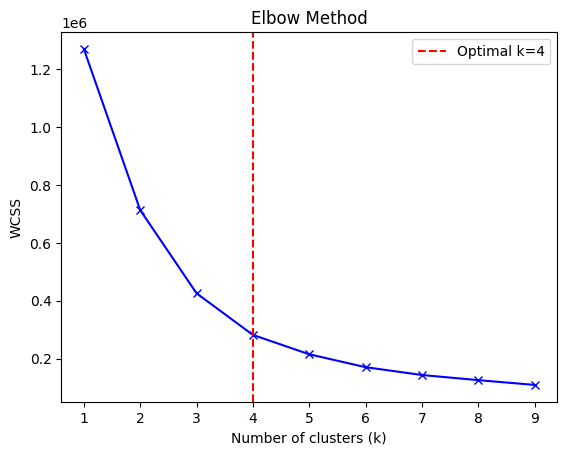

Optimal number of clusters: 4


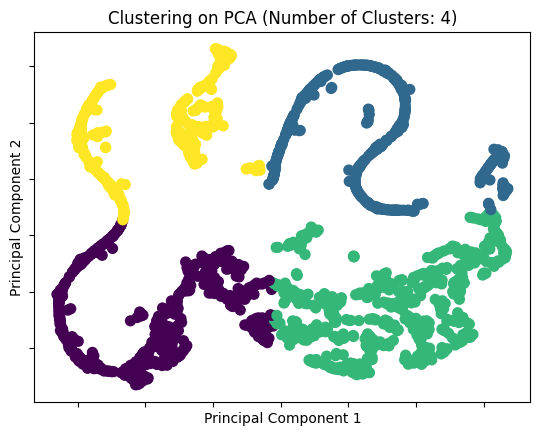

Silhouette score: 0.45481542


In [36]:
app = App("mura_data.csv")
app.start()